In [2]:
import numpy as np
import matplotlib.pyplot as plt

## loading the input data

In [3]:
def load_data(filename):
    with open(filename, 'r') as f:
        lines = f.read().split('\n')
    lines = [line for line in lines if line.strip() != '']
    lines = [line for line in lines if not line.strip().startswith('@')]
    data = np.array([list(map(float, line.split(','))) for line in lines])
    return data[:,:14], data[:, 14]

In [4]:
x_raw, y_raw = load_data('EEG Eye State.arff')
x_raw.shape, y_raw.shape

((14980, 14), (14980,))

In [5]:
def train_test_split(x, y, ratio=0.8):
    n_train = int(x.shape[0] * ratio)
    x_train = x[:n_train, :]
    y_train = y[:n_train]
    x_test = x[n_train:, :]
    y_test = y[n_train:]
    return x_train, y_train, x_test, y_test

In [6]:
x_train, y_train, x_test, y_test = train_test_split(x_raw, y_raw, ratio=0.8)

Find outliers (based on mean and standard deviation in training data)

In [7]:
x_zscores = (x_raw - x_train.mean(axis=0)) / x_train.std(axis=0)
n_outliers = np.sum((x_zscores >= 4).any(axis=1))
print(f'found {n_outliers} outliers')

found 96 outliers


Remove outliers

In [8]:
filter_outliers = (x_zscores < 4).all(axis=1)
x_clean = x_raw[filter_outliers, :]
y_clean = y_raw[filter_outliers]
x_clean.shape, y_clean.shape

((14884, 14), (14884,))

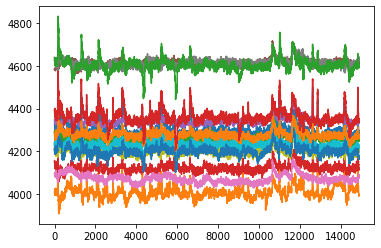

In [9]:
for i in range(x_clean.shape[1]):
    plt.plot(x_clean[:,i])

In [10]:
x_train, y_train, x_test, y_test = train_test_split(x_clean, y_clean, ratio=0.8)

Normalize the data to have zero-mean and unit-variance (computed on the training data)

In [11]:
mu = x_train.mean(axis=0)
std = x_train.std(axis=0)
x_train = (x_train - mu) / std
x_test = (x_test - mu) / std

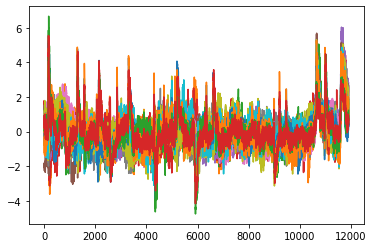

In [12]:
for i in range(x_train.shape[1]):
    plt.plot(x_train[:,i])

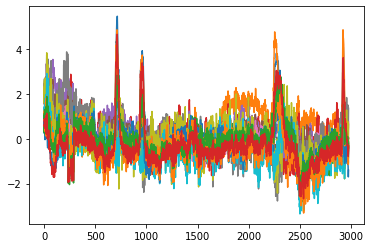

In [13]:
for i in range(x_test.shape[1]):
    plt.plot(x_test[:,i])

## setting up reservoir

In [131]:
n_neurons = 1000
n_outputs = 80
n_inputs = x_train.shape[1]
leak = 0.2

In [132]:
win = np.random.random((n_neurons, n_inputs+1)) - 0.5
w = np.random.random((n_neurons, n_neurons)) - 0.5
# todo: wout
wout = np.random.random((n_neurons, n_outputs)) - 0.5

In [133]:
win.shape

(1000, 15)

collect states from the reservoir

In [134]:
states = np.zeros((x_train.shape[0], n_neurons))
state = np.zeros((n_neurons,))
for t in range(x_train.shape[0]):
    u = x_train[t, :]
    state = (1. - leak) * state + leak * np.tanh(win @ np.concatenate((u, np.ones(1,)), axis=0) + w @ state)
    states[t,:] = state

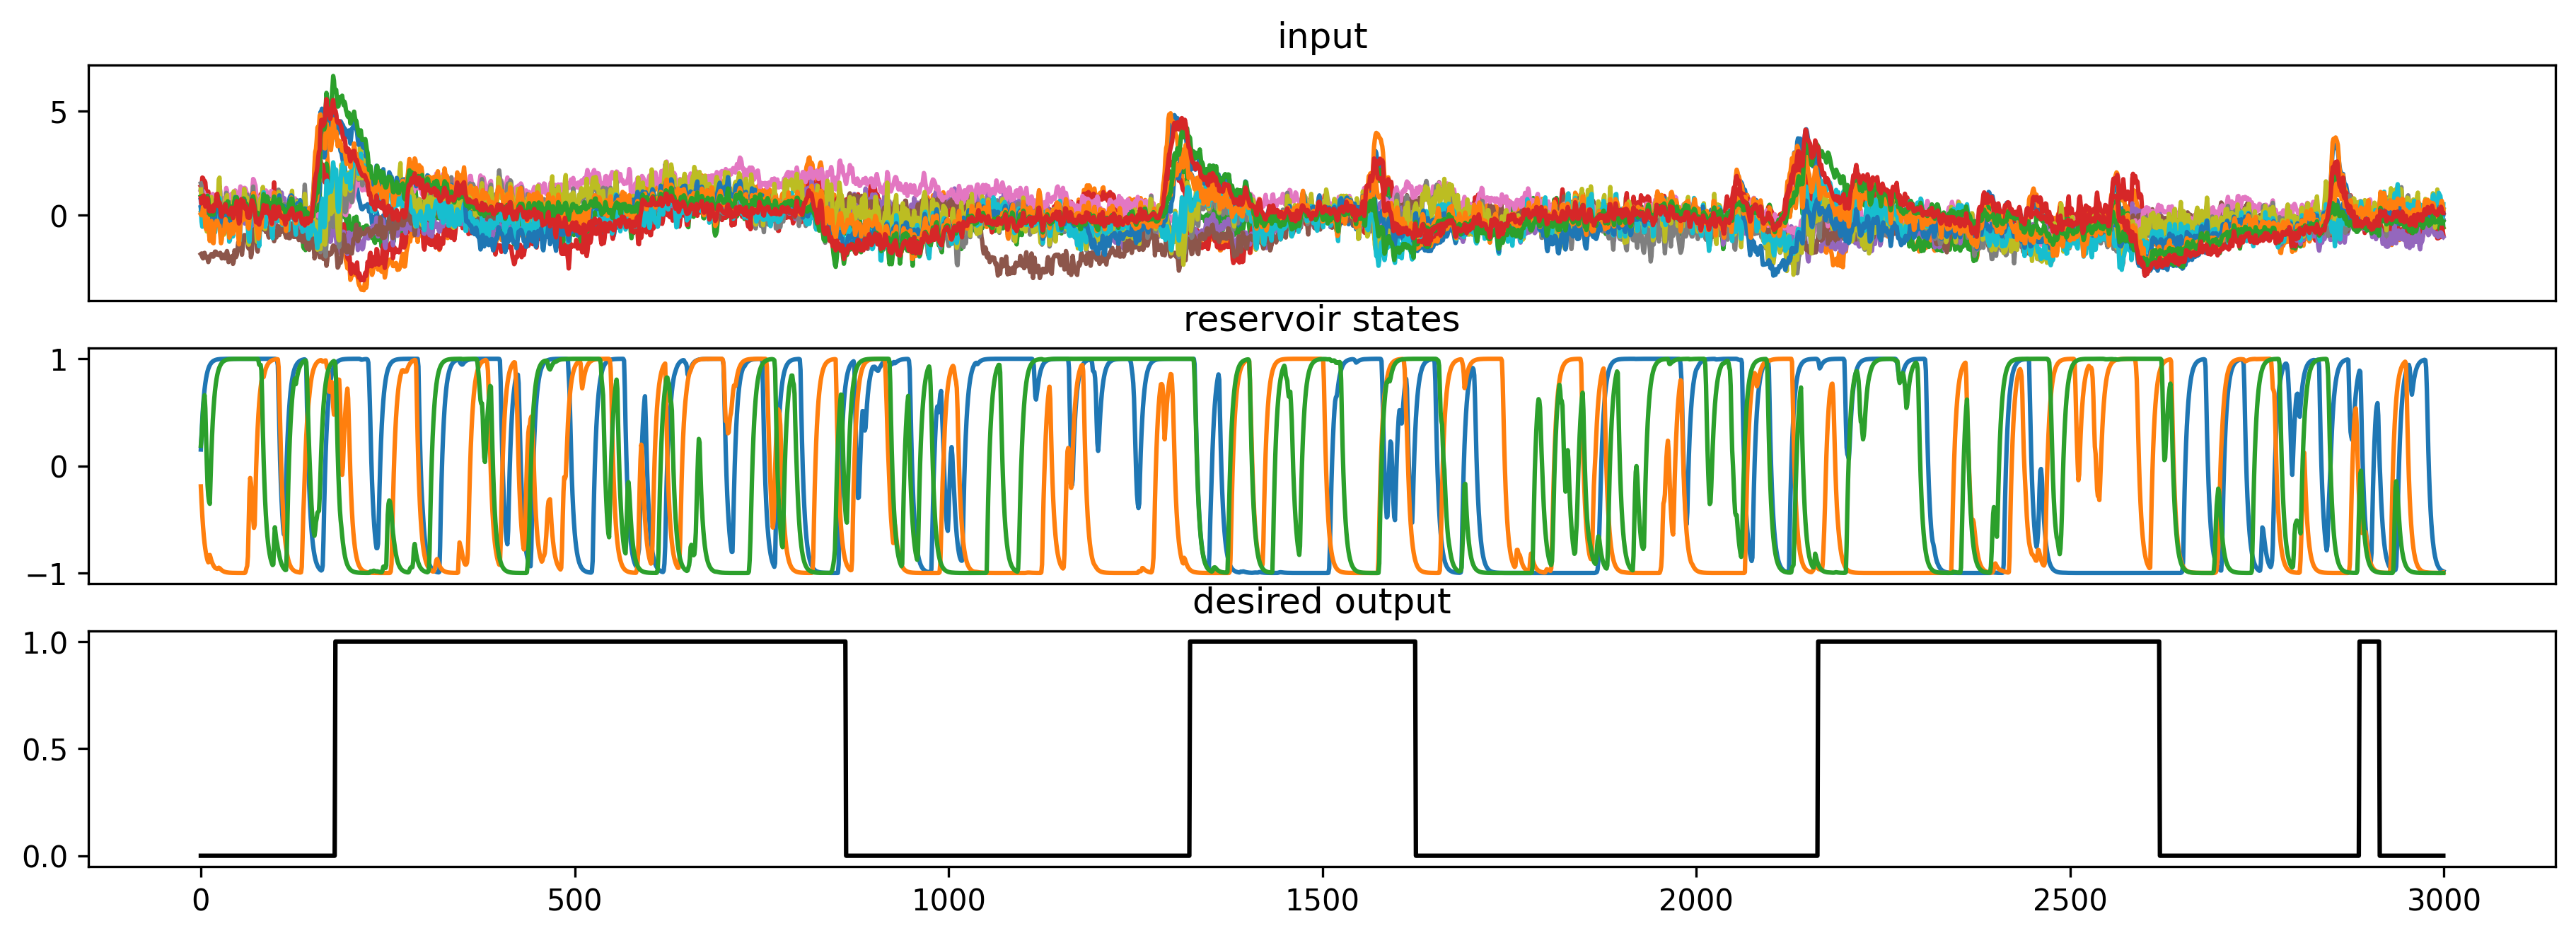

In [135]:
fig, axs = plt.subplots(nrows=3, ncols=1, sharex=False, figsize=(15,5), dpi=300)
axs[0].set_title('input')
axs[0].plot(x_train[:3000, :])
axs[0].set_xticks([])
axs[1].set_title('reservoir states')
axs[1].plot(states[:3000, :3])
axs[1].set_xticks([])
axs[2].set_title('desired output')
axs[2].plot(y_train[:3000], c='k')
plt.show()

train the reservoir's output weights

In [241]:
states.shape

(11907, 1000)

In [242]:
T_washout = 200

In [245]:
# closed form linear regression
wout_lr = np.linalg.pinv(states[T_washout:]) @ y_train[T_washout:].reshape((-1, 1))

In [246]:
# closed form ridge regression
alpha = 1e-3
S = states[T_washout:, :]
D = y_train[T_washout:].reshape((-1, 1))
R = (S.T @ S)  # / states.shape[0]
P = (S.T @ D)  # / states.shape[0]
wout_rr = np.linalg.inv((R + alpha * np.eye(n_neurons))) @ P

In [247]:
# solver for ridge regression
a = S.T @ S + alpha * np.eye(n_neurons)
b = S.T @ y_train[T_washout:]
wout_srr = np.linalg.solve(a, b)
# make sure solver and closed for solution are (nearly) the same
np.allclose(wout_rr[:,0], wout_srr)

True

In [248]:
y_train_pred_lr = states @ wout_lr
y_train_pred_rr = states @ wout_rr

In [249]:
def process_y_pred(y_pred):
    y = np.round(y_pred)
    y[y > 1] = 1
    y[y < 0] = 0
    return y

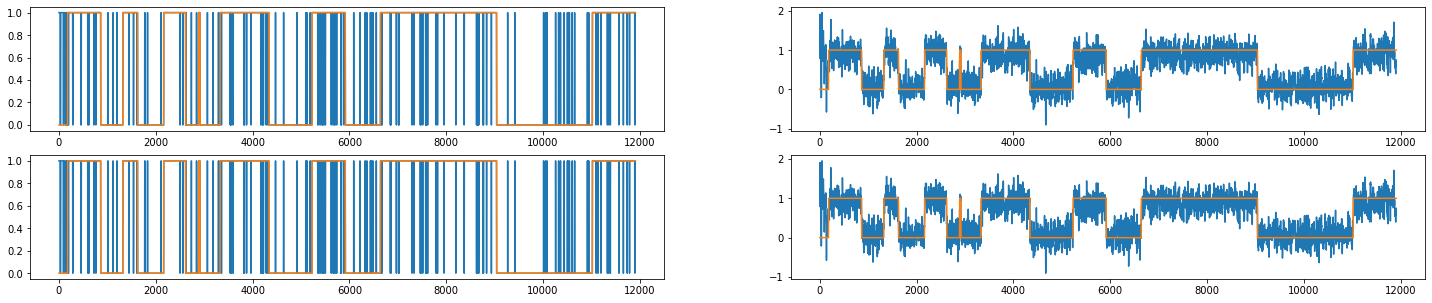

In [250]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(25,5))
axs[0][0].plot(process_y_pred(y_train_pred_lr))
axs[0][1].plot(y_train_pred_lr)
axs[1][0].plot(process_y_pred(y_train_pred_rr))
axs[1][1].plot(y_train_pred_rr)
axs[0][0].plot(y_train)
axs[0][1].plot(y_train)
axs[1][0].plot(y_train)
axs[1][1].plot(y_train)
plt.show()